# The Daubechies D4 Wavelet Tranform

In [56]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt



def split_matrix(matrix): # divide the matrix into 4 quadrants
    leftSide, rightSide = np.split(matrix, 2, axis=1)
    appr, vD = np.split(leftSide, 2, axis=0)
    hD, dD = np.split(rightSide, 2, axis=0)
    
    return appr, hD, vD, dD

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def p_new(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix

In [57]:
def daubechies_coeffs(image, rows):

    matrix_coeffs = np.zeros((rows, rows))

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))

def obtener_submatriz(matriz):
    n = len(matriz)
    submatriz = [fila[:n//2] for fila in matriz[:n//2]]
    return submatriz

def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,row, scale):
    result_H = []


    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))

    result_V = np.dot(daubechies_coeffs,result_H)

    if(scale == 2):
        result_V = obtener_submatriz(result_V)


    return result_V
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, result_V):
    daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
    result_H = np.dot(daubechies_coeffs_transpose, result_V)

    image = []
    for row in result_H:
        original_row = np.dot(daubechies_coeffs_transpose, row)
        image.append(original_row)

    return np.array(image)

root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

# Hide

In [58]:
example = np.random.randint(0.0, 52.0, (6, 6))
example_daubechies_4 = daubechies_coeffs(np.zeros_like(example))
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


TypeError: daubechies_coeffs() missing 1 required positional argument: 'rows'

In [ ]:
dwt = daubechies4_wavelet_transform_2D(example_daubechies_4,example)
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt)
print(f"\nOriginal Matrix:\n {example}")
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(dwt,4)}")
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(idwt,0)}")



Original Matrix:
 [[44 23 27 33 42 10]
 [51 49 15 29  9 22]
 [ 5 18 49 48 49 39]
 [10  7 14 33 31  6]
 [ 3 37  3 28 49  1]
 [35 11  3 40 15 20]]

Direct Daubechies Wavelet Transform:
 [[ 78.7309  59.5975  50.0345 -14.0975  -0.9307  15.1524]
 [ 22.5376  70.9883  45.0805  -0.9258  22.4277 -16.9576]
 [ 33.3268  54.0612  39.634  -27.9027  16.7818   6.4524]
 [ -6.0969  25.5852  24.938   19.2133  -2.3771 -21.4318]
 [  9.1808  -5.4632  -9.5333  -5.0859  27.6792 -24.1952]
 [ -4.7976  13.3565   6.8295  13.5648  18.8818   7.7504]]

Direct Daubechies Wavelet Transform:
 [[44. 23. 27. 33. 42. 10.]
 [51. 49. 15. 29.  9. 22.]
 [ 5. 18. 49. 48. 49. 39.]
 [10.  7. 14. 33. 31.  6.]
 [ 3. 37.  3. 28. 49.  1.]
 [35. 11.  3. 40. 15. 20.]]


# IMAGES EXAMPLES

In [ ]:
photo = "/home/juanca632/PersonalProjects/stage/wavelet-transform/image_gray.jpg"
scale = 2

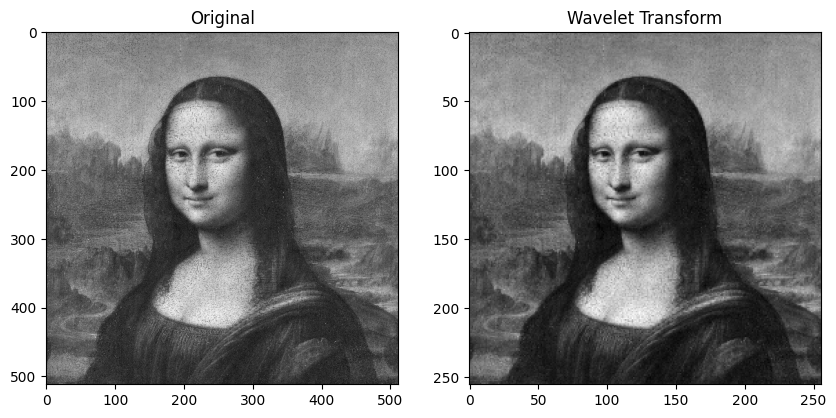

In [ ]:
array_photo = jpg_to_pgm(photo)
rows, cols = array_photo.shape
daubechies_4 = daubechies_coeffs(array_photo, rows)
result_img = daubechies4_wavelet_transform_2D(daubechies_4,array_photo,rows, scale)
# reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img)

# aP,cH,cV,cD = split_matrix(result_img)

# sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img), cmap='gray')
ax[1].set_title('Wavelet Transform')
# ax[2].imshow((reconstructed), cmap='gray')
# ax[2].set_title('Reconstructed')
plt.show()
#########
# fig, axes = plt.subplots(1, 4, figsize=(10, 10))
# axes[0].imshow(p_new(aP), cmap='gray')
# axes[0].set_title('Aproximación')
# axes[1].imshow(p_new(cH), cmap='gray')
# axes[1].set_title('Horizontal')
# axes[2].imshow(p_new(cV), cmap='gray')
# axes[2].set_title('Vertical')
# axes[3].imshow(p_new(cD), cmap='gray')
# axes[3].set_title('Diagonal')

# plt.tight_layout()
# plt.show()

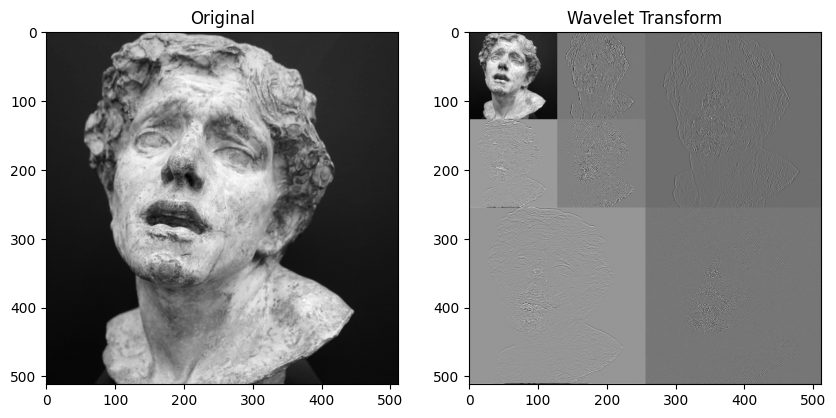

In [ ]:
result_img2 = daubechies4_wavelet_transform_2D(daubechies_coeffs(aP),aP)

aP1,cH1,cV1,cD1 = split_matrix(result_img2)
sup_img = np.concatenate((p_new(aP1),p_new(cH1)), axis=1)
inf_img = np.concatenate((p_new(cV1),p_new(cD1)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)


sup_img = np.concatenate((result_img2,p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

## Others examples

In [ ]:
photo = 'mario.png'

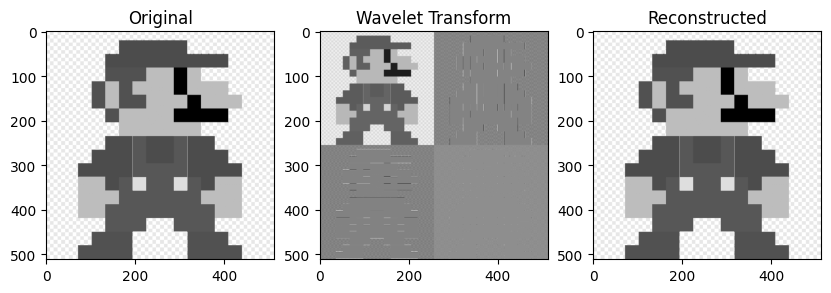

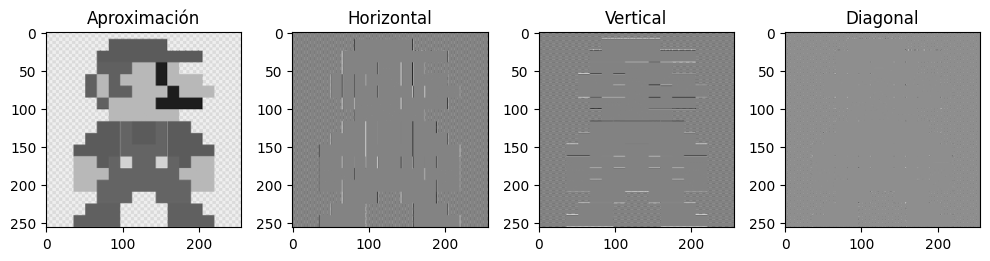

In [ ]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()

In [ ]:
photo = 'imagen2.jpeg'

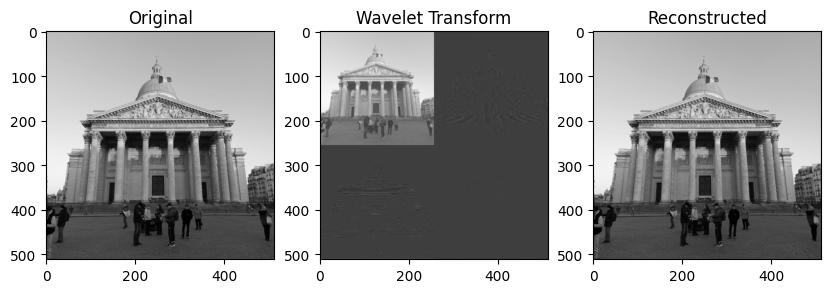

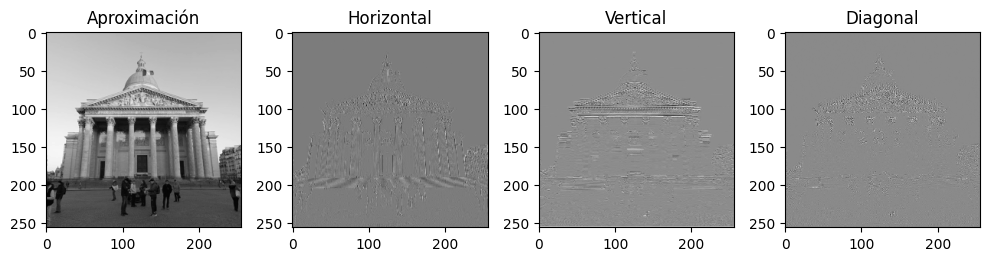

In [ ]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

# sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()